In [1]:
from utils import load_display_options, ignore_warnings
load_display_options()
ignore_warnings()

In [2]:
from visualisation.visualise import load_fonts, load_mpl_style
visualisation_path = "/Users/ciaran/Documents/Projects/AFL/git-repositories/afl-playing-styles/src/visualisation"
font_path = visualisation_path + "/fonts"
# style_path = visualisation_path + "/mplstyle/lilac_pitch_clusters.mplstyle"

load_fonts(font_path)
# load_mpl_style(style_path)

In [3]:
import pandas as pd
import seaborn as sns
from clustering.clustering import GMM

Load Chain Data

In [4]:
chains = pd.read_csv("/Users/ciaran/Documents/Projects/AFL/git-repositories/afl-playing-styles/data/playing_style_chains_v2.csv")
match_id = "2022F4_Geelong_Sydney"
team = "Geelong"

Get Plot Data

In [5]:
from chain_utils import get_match, get_team

In [6]:
def get_possession_start_end(chains):
    
    chains_no_shots = chains[chains['Shot_At_Goal'] != True]
    chain_start = chains_no_shots.groupby('Chain_Number').first()[['left_right_start_x', 'left_right_start_y']]
    chain_end = chains_no_shots.groupby('Chain_Number').last()[['left_right_end_x', 'left_right_end_y']]
    possessions = chain_start.merge(chain_end, left_index=True, right_index=True).reset_index()
    
    return possessions

In [7]:
def get_possession_data(chains, match_id, team):
    
    match_chains = get_match(chains, match_id=match_id)
    team_chains = get_team(match_chains, team=team)
    possessions = get_possession_start_end(team_chains)
        
    return possessions

In [8]:
clusters = 10

In [9]:
def create_possession_clusters(chains, match_id, team, clusters):
    
    possessions = get_possession_data(chains, match_id=match_id, team=team)
    possessions['GMM_'+str(clusters)] = GMM(clusters=clusters, data=possessions[['left_right_start_x', 'left_right_start_y', 'left_right_end_x', 'left_right_end_y']])
    
    return possessions

In [10]:
possessions = create_possession_clusters(chains, match_id, team, clusters=10)
possessions.head()

,Chain_Number,left_right_start_x,left_right_start_y,left_right_end_x,left_right_end_y,GMM_10
0,1,1.0,-2.0,21.0,3.0,7
1,2,23.0,52.0,62.0,38.0,3
2,4,47.0,41.0,60.0,-11.0,3
3,6,38.0,-57.0,44.0,-58.0,0
4,7,26.0,-39.0,-60.0,20.0,8


In [11]:
def merge_clusters_to_chains(chains, possessions, clusters):
    chains_possessions = chains.merge(possessions[['Chain_Number', "GMM_"+str(clusters)]], how = 'left', on = 'Chain_Number')
    chains_possessions = chains_possessions[chains_possessions['Shot_At_Goal'] != True]
    
    return chains_possessions

Plot Clusters on Pitch

In [14]:
from visualisation.plotting_pitches import plot_vertical_pitch_ax
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
colour_cycle=sns.color_palette("pastel", 100)
top_n = 3

In [ ]:
fig, ax = plt.subplots()
fig.dpi = 250
pitch, ax = plot_vertical_pitch_ax(ax)
for rank in np.linspace(0, top_n-1, top_n):
    cluster = team_chains_possessions['GMM_10'].value_counts().index[rank]     
    clustered = team_chains_possessions.loc[team_chains_possessions["GMM_10"] == cluster]
    for chain_num in list(clustered['Chain_Number'].unique()):
        possession = clustered[clustered['Chain_Number'] == chain_num]
        pitch.arrows(possession['left_right_start_x'], possession['left_right_start_y'], 
                    possession['left_right_end_x'], possession['left_right_end_y'], ax=ax, 
                    color = colour_cycle[int(rank)],
                    width=1, vertical = True)

In [23]:
def plot_possession_clusters_pitch_ax(pitch, ax, data, colour_cycle, label = "label", top_n = 3):
                
    for rank in np.linspace(0, top_n-1, top_n):
        cluster = data[label].value_counts().index[rank]     
        clustered = data.loc[data[label] == cluster]
        for chain_num in list(clustered['Chain_Number'].unique()):
            possession = clustered[clustered['Chain_Number'] == chain_num]
            pitch.arrows(possession['left_right_start_x'], possession['left_right_start_y'], 
                         possession['left_right_end_x'], possession['left_right_end_y'], ax=ax, 
                         color = colour_cycle[int(rank)], alpha = 0.8,
                         width=1, vertical = True)
    
    return pitch, ax

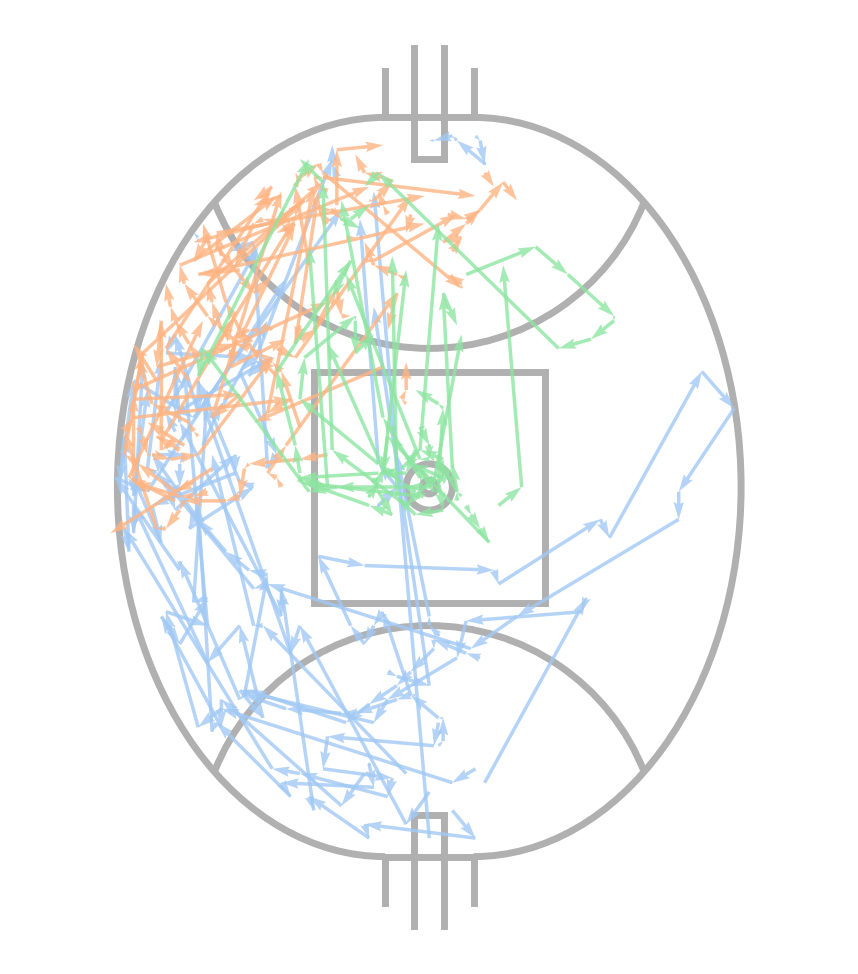

In [25]:
fig, ax = plt.subplots()
fig.dpi = 250
possessions = create_possession_plot_data(chains, match_id, team, clusters=10)
pitch, ax = plot_vertical_pitch_ax(ax)
pitch, ax = plot_possession_clusters_pitch_ax(pitch, ax, data=possessions, 
                                            colour_cycle=sns.color_palette("pastel", 10),
                                            label='GMM_'+str(10), top_n=3)

In [18]:
def create_possession_plot_data(chains, match_id, team, clusters):
    
    possessions_clusters = create_possession_clusters(chains, match_id=match_id, team=team, clusters=clusters)
    match_chains = get_match(chains, match_id)
    team_chains = get_team(match_chains, team)
    chain_possessions = merge_clusters_to_chains(team_chains, possessions_clusters, clusters)
        
    return chain_possessions

In [20]:
possessions = create_possession_plot_data(chains, match_id, team, clusters)
possessions.shape

(792, 231)

In [21]:
possessions = create_possession_plot_data(chains, match_id, team, clusters)
pitch, ax = plot_vertical_pitch_ax(ax)
pitch, ax = plot_possession_clusters_pitch_ax(pitch, ax, data=possessions, 
                                            colour_cycle=sns.color_palette("pastel", clusters),
                                            label='GMM_'+str(clusters), top_n=top_n)

NameError: name 'ax' is not defined